In [1]:
%%capture
from __future__ import division
import numpy as np
import numpy.linalg as linalg
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
plt.gray()

## 2.1
#### 2D-Operationen auf Bildern (5 Punkte)  
In der Vorlesung wurde gezeigt, das große Bereiche natürlicher Bilder homogen sind, die meisten Informationen über ein Bild jedoch in den Kanten und Diskontinuitäten zu finden sind. In disem Übungsblatt
soll es darum gehen, Kanten und herausragende Punkte in Bildern zu finden. 
Häufige Grundlage der Verarbeitung von Bildern ist das Anwenden von Filtern. Es entspricht der Faltung
(engl. convolution) des Bildes mit einem Filterkern. Filterkerne werden zu sehr verschiedenen Zwecken
eingesetzt.


### 2.1 (b)
Lade ein Testbild und wandle es anschließend in ein Grauwertbild mit float-Werten in [0, 1] um.

array([[0.6313726 , 0.63529414, 0.6392157 ],
       [0.63529414, 0.63529414, 0.63529414],
       [0.63529414, 0.63529414, 0.63529414]], dtype=float32)

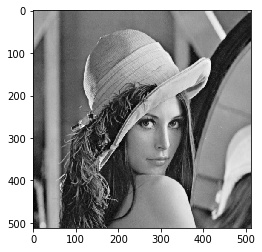

In [2]:
img_colored = cv2.imread("lena.png")
img_gray = cv2.cvtColor(img_colored, cv2.COLOR_BGR2GRAY)
img_normalized = img_gray.astype(np.float32) / 255.
plt.imshow(img_normalized)
img = img_normalized
img[:3,:3]

###  2.1 (c)
Falte ein verrauschtes Testbild mit Gaußfunktionen verschiedener Varianzen. Was passiert? Welchen
Einfluss hat die Kernelgröße?


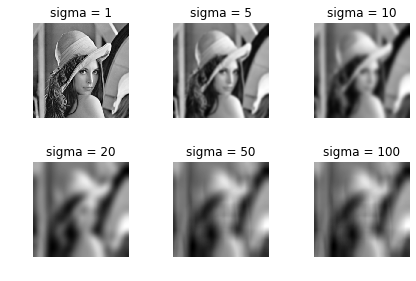

In [3]:
def get_gaussian_2d(size, sigma):
    kernel1d = cv2.getGaussianKernel(size, sigma)
    return kernel1d @ kernel1d.T

size = 71
sigmas = [1, 5, 10, 20, 50, 100]
imgs_filtered = []
n_columns = 3
n_rows = int(np.ceil(len(sigmas) / n_columns))
fig, axes = plt.subplots(n_rows, n_columns)
for ax, sigma in zip(axes.ravel(), sigmas):
    ax.axis('off')
    ax.set_title("sigma = {}".format(sigma))
    kernel = get_gaussian_2d(size, sigma)
    img_filtered = cv2.filter2D(img, cv2.CV_32F, kernel)
    imgs_filtered.append(img_filtered)
    ax.imshow(img_filtered)
   
plt.tight_layout()

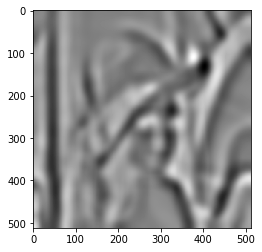

In [4]:
plt.imshow(imgs_filtered[5]-imgs_filtered[2])

### 2.3 Features (10 Punkte)
Kanten in Bildern werden häufig als Intensitätssprünge beschrieben.  
**(a)**  
Berechne den Betrag des Gradienten eines Testbildes und bestimme Schwellwerte des Gradienten,
um möglichst alle Kanten zu entdecken oder möglichst nur stark ausgeprägte Kanten zu entdecken.  
**(b)**  
Vergleiche mit dem Ergebnis des Canny-Kantendetektors (Canny), wenn er mit diesen Parametern aufgerufen wird.

sobel_y:
 [[-1 -2 -1]
 [ 0  0  0]
 [ 1  2  1]]


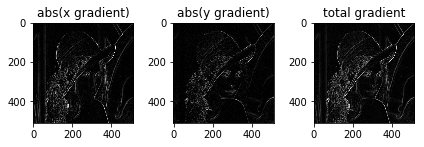

In [5]:
sobel_x = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1],
])
sobel_y = sobel_x.T # transpose
print("sobel_y:\n", sobel_y)
grad_x = abs(cv2.filter2D(img, cv2.CV_32F, sobel_x))
grad_y = abs(cv2.filter2D(img, cv2.CV_32F ,sobel_y))
grad_sum = grad_x + grad_y
_, axes = plt.subplots(1, 3)
axes[0].imshow(grad_x)
axes[0].set_title("abs(x gradient)")
axes[1].imshow(grad_y)
axes[1].set_title("abs(y gradient)")
axes[2].imshow(grad_sum)
axes[2].set_title("total gradient")
plt.tight_layout()

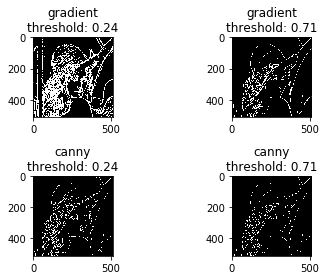

In [6]:
mean = grad_sum.mean()
thresholds = np.array([1, 3]) * mean
_, axes = plt.subplots(2, 2)
for ax, thr in zip(axes.T, thresholds):
    ax[0].set_title("gradient\nthreshold: {:.2f}".format(thr))
    _, img_binary = cv2.threshold(grad_sum, thr, 1, cv2.THRESH_BINARY)
    ax[0].imshow(img_binary)
    canny = cv2.Canny(img_gray, thr*255, 255)
    ax[1].imshow(canny)
    ax[1].set_title("canny\nthreshold: {:.2f}".format(thr))
plt.tight_layout()

Einzelne herausragende Punkte werden auch als Featurepunkte oder Ecken bezeichnet, selbst wenn sie
nicht auf einer Kante liegen.
* Implementiere die Harris-Corner Detektion. Verwende dabei nicht die OpenCV Methode cornerHarris, sondern implementiere selbst eine Funktion, die ein Grauwertbild, einen Parameter $k$ für die Berechnung des Featureindikators und einen Schwellwert $t$ für ausreichend großen Ausschlag des Indikators entgegennimmt und die Featurepunkte zurückgibt.
* Zeige die Werte des Detektors vor der Segmentierung mit dem Schwellwert $t$ unter Verwendung einer geigneten Color Map (applyColorMap) mit geeigneter Skalierung.
* Zeichne einen Kreis um jede gefundene Harris-Corner.


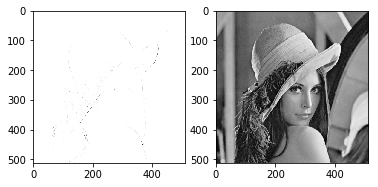

In [11]:
def harrisCorner(img, k, t):
    dx_filter = np.array([
        [-1 ,1],
        [-1, 1]
    ])
    dy_filter = dx_filter.T
    dx = cv2.filter2D(img, cv2.CV_32F, sobel_x)
    dy = cv2.filter2D(img, cv2.CV_32F, dy_filter)
    corners = np.zeros(img.shape)
    n_rows, n_cols = dx.shape
    for i in range(n_rows):
        for j in range(n_cols):
            deltas = np.array([dx[i, j], dy[i, j]]).reshape([2, 1])
            M = deltas @ deltas.T
            corners[i, j] = linalg.det(M) - k * M.trace()**2
    corners *= (100 - corners.min()) / (corners.max() - corners.min())
    corners -= corners.min()
    #_, corners = cv2.threshold(corners, 80, 100, cv2.THRESH_BINARY)
    return corners

corners = harrisCorner(img, 0.05, -1)
_, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(corners)
ax2.imshow(img)

[[  0   0   0 ... 511 511 511]
 [  0   1   2 ... 509 510 511]]


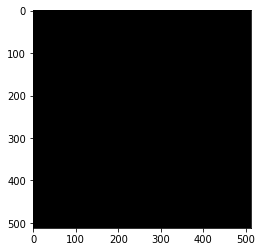

In [8]:
img_copy = img_colored.copy()
points = np.asarray(np.where(corners >90))
print(points)
for point in zip(*points):
    cv2.circle(img_copy, point, 1, (0, 0, 0), -1)
plt.imshow(img_copy)

In [9]:
cv_corners = cv2.cornerHarris(img_gray, 2, 3, 0.04)
img_corners = img_gray.copy()
for i in row in cv_corners:
    for corner in row:
        if corner > 0.3 * cv_corners.max()

SyntaxError: invalid syntax (<ipython-input-9-8bc1373cf8f3>, line 5)

In [ ]:
cv_corners.max()